In [1]:
#pip install opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 37.1 MB 269 kB/s eta 0:00:01     |█████████████████████████████▏  | 33.9 MB 725 kB/s eta 0:00:05     |█████████████████████████████▌  | 34.3 MB 1.3 MB/s eta 0:00:03
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import random
import math
import sys
import os
#import cv2
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
from shutil import copy
from sklearn.metrics import confusion_matrix
import time

split dataset if needed

In [30]:
#run only once for data_split

'''

# Organize sign_lang data set for training
split_root = "./Sign-Language-Digits-Dataset/Dataset"
dest_root = "./Dataset"

def sl_data_split(split_root , dest_root):
    for letter in  os.listdir(os.path.join(split_root)):
        for cnt,img in enumerate(os.listdir(os.path.join(split_root,letter))):
            img_str = letter + '-' + img
            if cnt/len(os.listdir(os.path.join(split_root,letter))) < 0.8:  # split up for training and testing
                if not os.path.exists(os.path.join(dest_root,'train',letter,img_str)):
                    copy(os.path.join(split_root,letter,img), os.path.join(dest_root,'train',letter,img_str))
            else:
                if not os.path.exists(os.path.join(dest_root,'test',letter,img_str)):
                    copy(os.path.join(split_root,letter,img), os.path.join(dest_root,'test',letter,img_str))
                    
make_dataset = sl_data_split(split_root=split_root, dest_root=dest_root)

'''

pre-process the images

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

BATCH_SIZE = 32

path1 = "./Dataset"

classes = ['0', '1', '2', '3', '4', '5','6','7','8','9']
n_classes = len(classes)

def data_loader(root=path1):
        # Define image transforms
    train_transform = transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            #transforms.RandomRotation(10),
            #transforms.Resize((224,224)),
            #transforms.Resize((7,7)),
            transforms.Resize((28,28)),
            transforms.ToTensor(),
            #transforms.Normalize([0.5, 0.5, 0.5],     # standard normalization values
             #                    [0.5, 0.5, 0.5])
            ])   

    test_transform = transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            #transforms.Resize((224,224)),
            #transforms.Resize((7,7)),
            transforms.Resize((28,28)),
            transforms.ToTensor(),
            #transforms.Normalize([0.5, 0.5, 0.5],     # standard normalization values
             #                    [0.5, 0.5, 0.5])
            ])

    train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
    test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)


    #train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
    #test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, test_loader

train_loader, test_loader = data_loader(root=path1)

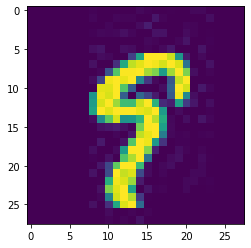

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[2., 0., 0.,  ..., 0., 0., 0.],
          [0., 6., 9.,  ..., 0., 0., 0.],
          [0., 2., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [3]:
n = 20
cnt = 0

for m, (X_train, y_train) in enumerate(train_loader): 
    #if m == n:
        #print(X_train)
        #print(y_train)
    if cnt>=1: 
        break    
    img = X_train[0]   
    img = img.numpy()   
    img = np.transpose(img, (1,2,0))    

    plt.imshow(img)
    plt.show()
    print(X_train*255)
    print(y_train)
    print(X_train.shape)
    print(y_train.shape)
    cnt += 1
        

train functions

In [4]:
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def train_model(CNNmodel,epochs,train_loader,test_loader,criterion,optimizer,Batch_Size=20,print_every = 10, 
                LEARNING_RATE=0.001, lr_reduce=50, verbose=True,plot_results=True):
    
    start_time = time.time()
    batch_size = Batch_Size
    max_trn_batch = 800  # Limits very large datasets
    max_tst_batch = 300
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []
    losses=[]
    
    print('Training for {} epochs...\n'.format(epochs))
    
    for epoch in range(epochs):
        trn_corr = 0
        tst_corr = 0
        trn_loss = 0
        tst_loss = 0
        for m, (X_train, y_train) in enumerate(train_loader): # Run the training batches
            # Limit the number of batches
            if m == max_trn_batch: break
            m+=1

            y_pred = CNNmodel(X_train)  # Apply the model
            loss = criterion(y_pred, y_train)
            
            predicted = torch.max(y_pred.data, 1)[1] # Tally the number of correct predictions
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            optimizer.zero_grad()  # Update parameters
            loss.backward()
            optimizer.step()
            
            trn_loss += loss.item()
            
        train_losses.append(trn_loss)
        train_correct.append(trn_corr*100/(batch_size*m))

        with torch.no_grad():  # Run the testing batches
            for n, (X_test, y_test) in enumerate(test_loader):
                if n == max_tst_batch: break  # Limit the number of batches

                y_val = CNNmodel(X_test)  # Apply the model
                loss = criterion(y_val, y_test)
                tst_loss += loss.item()

                predicted = torch.max(y_val.data, 1)[1]  # Tally the number of correct predictions
                tst_corr += (predicted == y_test).sum()

        test_losses.append(tst_loss)
        test_correct.append(tst_corr*100/(batch_size*n))

        if verbose == True and epoch % print_every== 0: 
            print('\n\nEpoch {}/{}: train loss: {:.4f} | acc: {:.4f}%|   validation loss: {:.4f} | acc: {:.4f}%'
                  .format(epoch+1, epochs, trn_loss, trn_corr*100/(batch_size*m), tst_loss, tst_corr*100/(batch_size*n)), end=' ')
        if epoch+1 == epochs:
            print('\n\nFinal Accuracy:{:.4f}%'.format( tst_corr*100/(batch_size*n)))
            
                # adjust the LEARNING_RATE
        if epoch != 0 and epoch % lr_reduce == 0:
            LEARNING_RATE = LEARNING_RATE*0.5
            optimizer = optim.Adam(CNNmodel.parameters(),lr = LEARNING_RATE)
#            for param_group in optimizer.param_groups:
#                param_group['lr'] = LEARNING_RATE
            print('\n\n\nEpoch{}/{}: Set LEARNING_RATE = {:.8f}'.format(epoch+1, epochs, LEARNING_RATE))
    
        
    if verbose == True:        
        print('\nFinished Training  | Time:{}'.format(time.time()-start_time))
    if plot_results == True:
        plt.figure(figsize=(10,10))
        plt.plot(train_losses, label='train loss')
        plt.plot(test_losses, label='validation loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.draw()
        
        plt.figure(figsize=(10,10))
        plt.plot([t for t in train_correct], label='train accuracy')
        plt.plot([t for t in test_correct], label='validation accuracy')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.draw()
        
        return CNNmodel


model architecture

In [5]:
import onnx
import torch
from brevitas.nn import QuantConv2d, QuantIdentity, QuantMaxPool2d, QuantLinear,QuantDropout,QuantReLU
from brevitas.core.quant import QuantType
import torch.nn as nn
from torch import optim
from brevitas.quant import SignedTernaryActPerTensorConst,SignedBinaryActPerTensorConst

In [6]:
# mAlexNet

# did not change the architecture, but changed the kernel size and channels


class MNIST_2D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(MNIST_2D,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=16,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=16,out_channels=20,kernel_size=3,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(20)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=20,out_channels=30,kernel_size=3,
                               padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=None)

        self.drop1 = QuantDropout(p=0.5)
                                  
        self.fc1 = QuantLinear(2*2*30,5*12,bias=False,weight_bit_width=weight_bit_width)
        self.relu4 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(5*12,num_classes,bias=False,weight_bit_width=weight_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.bn_1(self.cnn1(x))))
        x = self.maxpool2(self.relu2(self.bn_2(self.cnn2(x))))
        x = self.maxpool3(self.relu3(self.cnn3(x)))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [7]:
input_size = 1 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = MNIST_2D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

In [8]:
LEARNING_RATE = 0.0004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
train_loader, test_loader = data_loader(root=path1)

Training for 10 epochs...



/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(




Epoch 1/10: train loss: 763.2709 | acc: 69.4570%|   validation loss: 131.1562 | acc: 87.0104% 

Epoch 6/10: train loss: 175.3605 | acc: 93.1484%|   validation loss: 67.6376 | acc: 93.1042% 

Final Accuracy:94.3021%

Finished Training  | Time:476.7978358268738


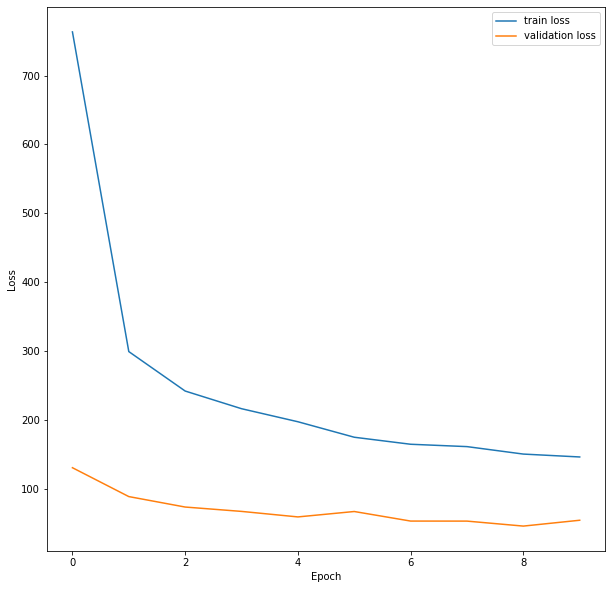

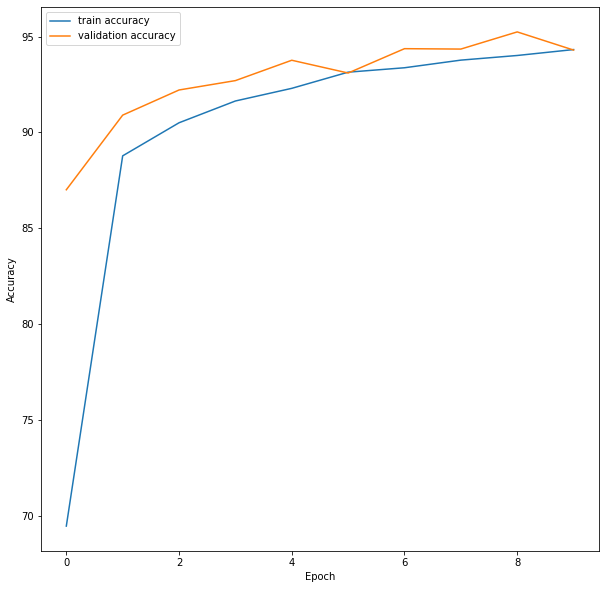

In [10]:
EPOCHS=10
lr_reduce=30
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 5, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

save parameters and export ONNX model

In [11]:
torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_28*28.pth')

In [12]:
import brevitas.onnx as bo

In [ ]:
export_onnx_path="./multi_model_test/save_model/model_2D_28*28.onnx"
input_shape=(1,1,28,28)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)